In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import sys
import time


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2017/11/20171101_block_party.png" width="300" height="300">

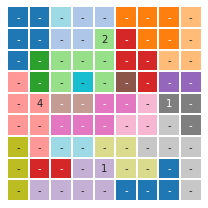

In [4]:
#set up the hooks


groups=np.array([[0 ,0 ,22,2 ,2 ,3 ,3 ,3 ,4 ],
                 [0 ,0 ,2 ,2 ,6 ,7 ,3 ,3 ,4 ],
                 [0 ,5 ,6 ,6 ,6 ,7 ,7 ,4 ,4 ],
                 [9 ,5 ,6 ,21,6 ,12,7 ,10,10],
                 [9 ,9 ,13,13,14,14,16,17,17],
                 [9 ,9 ,14,14,14,15,16,18,17],
                 [19,9 ,23,23,20,20,18,18,18],
                 [19,8 ,8 ,11,11,20,20,1 ,18],
                 [19,11,11,11,11,1 ,1 ,1 ,18]
                 ],dtype=int)

fixed =np.array([[0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,2,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,4,0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,1,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0]
                 ],dtype=int)

def grid_print(groups,numbers):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=1)
    ax.axis("off")
    plt.tight_layout()
    
grid_print(groups,fixed) 


In [5]:
#iterate through keeping track of the numbers left in each group

class Matrix():
    def __init__(self,groups,fixed):
        self.groups = groups
        self.fixed = fixed
        self.solution = []
        self.group_dict ={}
        for n in range(24):
            self.group_dict[n] = list(np.arange(1,np.sum(self.groups==n)+1))
    
    # check the ones forced by conditions(not many)
    def forced(self):
        changed =1
        while changed  ==1:
            changed =0
            for i,j in itertools.product(range(9),range(9)):
                group = self.groups[i,j]
                if self.fixed[i,j] == 0: 
                    if len(self.group_dict[group]) ==1:
                        num = self.group_dict[group].pop(0)
                        self.fixed[i,j] = num
                        changed = 1
                else:
                    num = self.fixed[i,j]
                    if num in self.group_dict[group]:
                        self.group_dict[group].remove(num)
                        changed=1    
                        
    #solve via backtracking
    def solve(self):
        for col,row in itertools.product(range(9),range(9)):
            
             if self.fixed[row,col]==0:
                group = self.groups[row,col]
                loop = dcopy(self.group_dict[group])
                for n in loop:
                    if self.possible(n,row,col):
                        self.fixed[row,col] = n
                        self.group_dict[group].remove(n)
                        self.solve()
                        self.fixed[row,col] = 0
                        self.group_dict[group].append(n)
                return
        if self.final_test():    
            self.solution.append(dcopy(self.fixed))
    
    
    #check placements
    def possible(self,n,row,col):
     
        for i in range(1,n):
             if np.any(self.n_neighbour(i,row,col)==n):
                    return False
                
        neighbours = self.n_neighbour(n,row,col)              
        if 0 not in neighbours:
            if n not in neighbours:
                return False 
        else:
            if n not in neighbours:
                if n not in self.poss_neighbour(n,row,col):
                    return False
            
        
            
        test =dcopy(self.fixed)
        for i,j in itertools.product(range(9),range(9)):
            num = self.fixed[i,j]
            if num ==n :
                neighbours = self.n_neighbour(num,i,j)
                if 0 not in neighbours:
                    if num not in neighbours:
                        return False
          
        return True
   
    #check all the neighbours at the end
    def final_test(self):
        for i,j in itertools.product(range(9),range(9)):
            num = self.fixed[i,j]
            neighbours = self.n_neighbour(num,i,j)
            if not np.any(num in neighbours):
                return False
        return True

    # work out the n_neighbours of a cell
    def n_neighbour(self,n,row,col):
        neighbours = []
        if row-n >-1:
            neighbours.append(self.fixed[row-n,col])
        if col-n >-1:
            neighbours.append(self.fixed[row,col-n])
        if row+n <9:
            neighbours.append(self.fixed[row+n,col])
        if col+n <9:
            neighbours.append(self.fixed[row,col+n])
        return neighbours
    
    #check possible neighbours
    def poss_neighbour(self,n,row,col):
        poss_neighbours = []
        if row-n >-1:
             if self.fixed[row-n,col] == 0:
                poss_neighbours += self.group_dict[self.groups[row-n,col]]
        if col-n >-1:
             if self.fixed[row,col-n] == 0:
                poss_neighbours += self.group_dict[self.groups[row,col-n]]
        if row+n <9:
             if self.fixed[row+n,col] == 0:
                poss_neighbours += self.group_dict[self.groups[row+n,col]]
        if col+n <9:
            if self.fixed[row,col+n] == 0:
                poss_neighbours += self.group_dict[self.groups[row,col+n]]
        #print(poss_neighbours)
        return poss_neighbours

def counter(groups,solved):
    group_poss = []
    for i in range(24):
        group_poss.append([0])
    
    group = 0
    total =0
    for i,j in itertools.product(range(9),range(9)):  
        num = solved[i,j]
        if groups[i,j] == group:
            total *=10
            total += num
        else:
            group_poss[group].append(total)
            group = groups[i,j]
            total = num
     
    prod = 0
    for i in range(24):
        prod +=max(group_poss[i])
        
    return prod

Forced took 0.000780 seconds

Solution took 11.657487 seconds

The sum of largest concatenated numbers is : 6,647


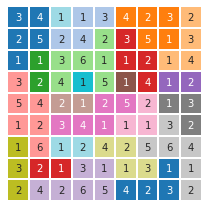

In [10]:
start = time.perf_counter()
matrix = Matrix(groups,fixed)  
matrix.forced()
print('Forced took {:0.6f} seconds\n'.format((time.perf_counter()-start)))
matrix.solve()
print('Solution took {:0.6f} seconds\n'.format((time.perf_counter()-start)))
grid_print(matrix.groups,matrix.solution[0])
#print(len(matrix.solution))
#print("number incorrect :",np.sum(matrix.solution[0]!=solved))
print("The sum of largest concatenated numbers is : {:,.0f}".format(counter(matrix.groups,matrix.solution[0])))

In [11]:
url='https://www.janestreet.com/puzzles/solutions/november-2017-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

There are two ways to complete this month’s puzzle, one of which is shown below. (The other comes from switching the 1 and 2 in the shaded region.) In either case, the sum of the largest concatenated values (the values in red) in each region is 6647


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2017/12/20171201_block_party_completed.png" width="250" height="400">

In [10]:
solved=np.array([[3,4,1,1,3,4,2,3,2],
                 [2,5,2,4,2,3,5,1,3],
                   [1,1,3,6,1,1,2,1,4],
                   [3,2,4,1,5,1,4,1,2],
                   [5,4,2,1,2,5,1,1,3],
                   [1,2,3,4,1,1,2,3,2],
                   [1,6,1,2,4,2,5,6,4],
                   [3,2,1,3,1,1,3,1,1],
                   [2,4,2,6,5,4,2,3,2]
                 ])